This is just a WIP script to visualized computed results.

In [1]:
# dependencies

from src.data_analysis.query_accuracy import query_accuracy, get_results_csv_path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial import ConvexHull
import glob
from copy import copy
import numpy as np
import pandas as pd
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid


%matplotlib inline
plt.rcParams["figure.figsize"] = [14, 8]
plt.style.use("ggplot")

In [2]:
# show a face from each condition
def show_faces_of_condition(
    condition: str, suffixes: list, grid_size: tuple, figsize: tuple = (6, 8)
):
    potential_faces = glob.glob("Datasets//lfw//**//*.jpg", recursive=True)
    face_real_path = potential_faces[np.random.randint(len(potential_faces))]

    face_storage = []
    real_img = cv2.imread(face_real_path)
    real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
    face_storage.append((real_img, "Real"))

    for suffix in suffixes:
        dataset_name = f"lfw_{condition}_{suffix}"
        current_path = face_real_path.replace(
            "Datasets//lfw", f"Anonymized Datasets//{dataset_name}"
        )

        try:
            face_img = cv2.imread(current_path)
            face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
            face_storage.append((face_img, suffix))
        except Exception as e:
            print(f"Warning: {suffix} not found, {e}.")

    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(
        fig,
        111,  # similar to subplot(111)
        nrows_ncols=grid_size,  # creates 2x2 grid of axes
        axes_pad=0.1,  # pad between axes in inch.
    )

    while len(face_storage) < grid_size[0] * grid_size[1]:
        face_storage.append((np.zeros_like(face_storage[0][0]), -1))

    for i, (ax, (im, suf)) in enumerate(zip(grid, face_storage)):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.text(10, 30, suf, color="b")
        ax.set_xticks([])
        ax.set_yticks([])

    grid[0].set_title(condition)
    plt.show()

In [3]:
# show a face from each condition
def show_multiple_faces_in_conditions(
    condition: str, suffixes: list, numfaces: int = 4, figsize: tuple = (6, 8)
):
    grid_size = (len(suffixes), numfaces)
    potential_faces = glob.glob("Datasets//lfw//**//*.jpg", recursive=True)

    face_storage = []

    for suffix in suffixes:
        dataset_name = f"lfw_{condition}_{suffix}"

        for i in range(numfaces):
            face_real_path = potential_faces[np.random.randint(len(potential_faces))]
            current_path = face_real_path.replace(
                "Datasets//lfw", f"Anonymized Datasets//{dataset_name}"
            )

            try:
                face_img = cv2.imread(current_path)
                face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
                face_storage.append((face_img, suffix))
            except Exception as e:
                print(f"Warning: {suffix} not found, {e}.")

    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(
        fig,
        111,  # similar to subplot(111)
        nrows_ncols=grid_size,  # creates 2x2 grid of axes
        axes_pad=0.1,  # pad between axes in inch.
    )

    while len(face_storage) < grid_size[0] * grid_size[1]:
        face_storage.append((np.zeros_like(face_storage[0][0]), -1))

    for i, (ax, (im, suf)) in enumerate(zip(grid, face_storage)):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.text(10, 30, suf, color="b")
        ax.set_xticks([])
        ax.set_yticks([])

    grid[0].set_title(condition)
    plt.show()

In [4]:
def plot_results(
    fig,
    ax,
    mechanism: str,
    x_values: list,
    suffixes: list,
    xlabel_name: str = "",
    legend_name: str = "",
):
    assert len(suffixes) == len(x_values)

    is_empty = not ax[0, 0].lines

    # having to find the actual number of entries in CelebA's test set
    celeba_paths = glob.glob("Datasets//CelebA_test//**//*.jpg", recursive=True)
    rank_k_denominator = len(celeba_paths)

    zeros = [0 for _ in range(len(suffixes))]
    (
        rank_k_accs,
        rank_k5_accs,
        val_accs,
        val2_accs,
        ssim_accs,
        emotion_class_accs,
        emotion_prob_accs,
    ) = (
        copy(zeros),
        copy(zeros),
        copy(zeros),
        copy(zeros),
        copy(zeros),
        copy(zeros),
        copy(zeros),
    )

    for i in range(len(suffixes)):
        suf = suffixes[i]
        if len(suf) > 0:
            suf = f"_{suf}"

        try:
            rank_k_accuracies = query_accuracy(
                "rank_k",
                dataset="CelebA_test",
                p_mech_suffix=f"{mechanism}{suf}",
                mode="mean",
                denominator=rank_k_denominator,
            )
            rank_k_accs[i] = rank_k_accuracies["1"]
            rank_k5_accs[i] = rank_k_accuracies["50"]
        except Exception as e:
            print(f"No data for {mechanism}{suf}, {e}.")

        try:
            val_acc = query_accuracy(
                "lfw_validation",
                dataset="lfw",
                p_mech_suffix=f"{mechanism}{suf}",
                mode="mean",
                denominator=3000,
            )
            val_accs[i] = val_acc
        except Exception as e:
            print(f"No data for {mechanism}{suf}, {e}.")

        try:
            val2_acc = query_accuracy(
                "validation",
                dataset="CelebA_test",
                p_mech_suffix=f"{mechanism}{suf}",
                mode="mean",
                denominator=5000,
            )
            val2_accs[i] = val2_acc
        except Exception as e:
            print(f"No data for {mechanism}{suf}, {e}.")

        try:
            util_acc = query_accuracy(
                "utility",
                dataset="CelebA_test",
                p_mech_suffix=f"{mechanism}{suf}",
                mode="mean",
                denominator=rank_k_denominator,
            )
            ssim_accs[i] = util_acc["ssim"]
            emotion_class_accs[i] = util_acc["emotion"]
            emotion_prob_accs[i] = 0
        except Exception as e:
            print(f"No data for {mechanism}_{suf}, {e}.")

    ax[0, 0].plot(x_values, rank_k_accs, label=legend_name, marker=".")
    ax[0, 1].plot(x_values, rank_k5_accs, label=legend_name, marker=".")
    ax[0, 2].plot(x_values, val_accs, label=legend_name, marker=".")
    ax[0, 3].plot(x_values, val2_accs, label=legend_name, marker=".")

    ax[1, 0].plot(x_values, ssim_accs, label=legend_name, marker=".")
    ax[1, 1].plot(x_values, emotion_class_accs, label=legend_name, marker=".")
    # random chance line
    if is_empty:
        ax[1, 1].plot(
            x_values,
            [1 / 7 for _ in range(len(x_values))],
            color="r",
            linestyle="--",
            alpha=0.5,
            label="random chance",
        )
    ax[1, 2].plot(x_values, emotion_prob_accs, label=legend_name, marker=".")

    fig.suptitle(mechanism)
    ax[0, 0].set_title("Rank K=1 on CelebA")
    ax[0, 1].set_title("Rank K=50 on CelebA")
    ax[0, 2].set_title("LFW Validation")
    ax[0, 3].set_title("Validation on CelebA")
    ax[1, 0].set_title("SSIM")
    ax[1, 1].set_title("Emotion Classification")
    ax[1, 2].set_title("Emotion Probability Error")
    ax[1, 3].set_title("TBD")

    for i in range(8):
        ii = i // 4
        jj = i % 4
        if min(x_values) < 1:
            ax[ii, jj].set_xscale("log")
        ax[ii, jj].set_xticks(
            x_values, [f"{z:.2f}" if z < 1 else f"{z:.1f}" for z in x_values]
        )
        ax[ii, jj].set_ylim([0, 1])
        ax[ii, jj].set_xlabel(xlabel_name)
        ax[ii, jj].legend()

In [5]:
def scatter_privacy_utility(
    fig,
    ax,
    mechanism: str,
    suffixes: list,
    color: tuple = (0, 0, 0),
    legend_name: str = "",
):
    # having to find the actual number of entries in CelebA's test set
    celeba_paths = glob.glob("Datasets//CelebA_test//**//*.jpg", recursive=True)
    rank_k_denominator = len(celeba_paths)

    zeros = [0 for _ in range(len(suffixes))]
    (
        rank_k_accs,
        val_accs,
        ssim_accs,
        emotion_class_accs,
    ) = (
        copy(zeros),
        copy(zeros),
        copy(zeros),
        copy(zeros),
    )

    for i in range(len(suffixes)):
        suf = suffixes[i]
        if len(suf) > 0:
            suf = f"_{suf}"

        try:
            rank_k_accuracies = query_accuracy(
                "rank_k",
                dataset="CelebA_test",
                p_mech_suffix=f"{mechanism}{suf}",
                mode="mean",
                denominator=rank_k_denominator,
            )
            rank_k_accs[i] = 1 - rank_k_accuracies["1"]
        except Exception as e:
            print(f"No data for {mechanism}{suf}, {e}.")

        try:
            val_acc = query_accuracy(
                "lfw_validation",
                dataset="lfw",
                p_mech_suffix=f"{mechanism}{suf}",
                mode="mean",
                denominator=3000,
            )
            val_accs[i] = 1 - val_acc
        except Exception as e:
            print(f"No data for {mechanism}{suf}, {e}.")

        try:
            util_acc = query_accuracy(
                "utility",
                dataset="CelebA_test",
                p_mech_suffix=f"{mechanism}{suf}",
                mode="mean",
                denominator=rank_k_denominator,
            )
            ssim_accs[i] = util_acc["ssim"]
            emotion_class_accs[i] = util_acc["emotion"]
        except Exception as e:
            print(f"No data for {mechanism}{suf}, {e}.")

    ax[0].scatter(
        rank_k_accs, emotion_class_accs, color=color, s=400, alpha=0.2, zorder=0
    )
    ax[0].scatter(rank_k_accs, emotion_class_accs, label=legend_name, color=color)
    ax[0].set_title("Rank-1 vs Emotion Classification")
    ax[0].set_xlabel("Privacy (1 - rank-1 ID rate)")
    ax[0].set_xticks([0, 0.5, 1], ["not private", "50%", "private"])
    ax[0].set_ylabel("Utility (emotion classification)")
    ax[0].set_yticks([0, 0.5, 1], ["no\nutility", "50%", "full\nutility"])
    ax[0].legend()

    ax[1].scatter(val_accs, ssim_accs, color=color, s=400, alpha=0.2, zorder=0)
    ax[1].scatter(val_accs, ssim_accs, label=legend_name, color=color)
    ax[1].set_title("LFW Validation vs SSIM")
    ax[1].set_xlabel("Privacy (1 - LFW validation)")
    ax[1].set_xticks([0, 0.5, 1], ["not private", "50%", "private"])
    ax[1].set_ylabel("Utility (SSIM)")
    ax[1].set_yticks([0, 0.5, 1], ["no\nutility", "50%", "full\nutility"])
    ax[1].legend()

Analyzing individual sessions:

No data for uniform_blur_k5, Results//Privacy//rank_k//CelebA_test_uniform_blur_k5.csv does not exist!.
No data for uniform_blur_k5, Results//Privacy//lfw_validation//lfw_uniform_blur_k5.csv does not exist!.
No data for uniform_blur_k5, Results//Privacy//validation//CelebA_test_uniform_blur_k5.csv does not exist!.
No data for uniform_blur__k5, Results//Utility//utility//CelebA_test_uniform_blur_k5.csv does not exist!.
No data for uniform_blur_k11, Results//Privacy//rank_k//CelebA_test_uniform_blur_k11.csv does not exist!.
No data for uniform_blur_k11, Results//Privacy//lfw_validation//lfw_uniform_blur_k11.csv does not exist!.
No data for uniform_blur_k11, Results//Privacy//validation//CelebA_test_uniform_blur_k11.csv does not exist!.
No data for uniform_blur__k11, Results//Utility//utility//CelebA_test_uniform_blur_k11.csv does not exist!.
No data for uniform_blur_k15, Results//Privacy//rank_k//CelebA_test_uniform_blur_k15.csv does not exist!.
No data for uniform_blur_k15, Results//Pri

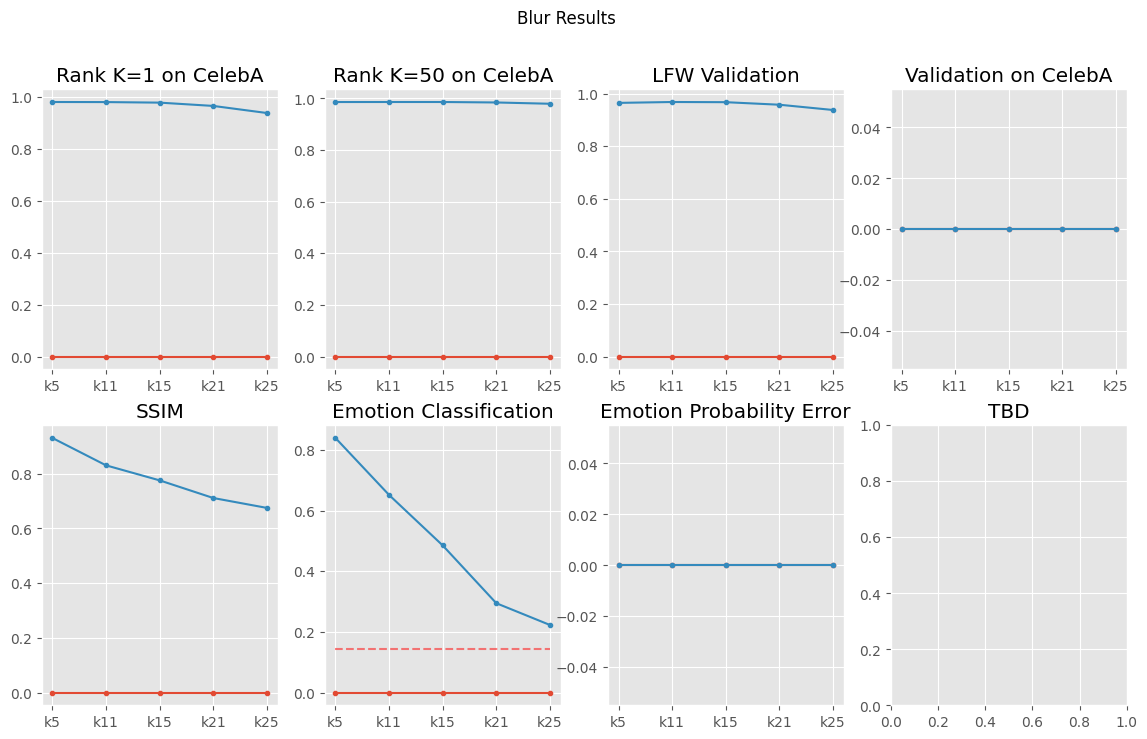

In [6]:
# looking at blurring results, comparing rank k on CelebA to lfw validation
fig, ax = plt.subplots(2, 4)
blur_kernels = [5, 11, 15, 21, 25]
for i in range(len(blur_kernels)):
    blur_kernels[i] = f"k{blur_kernels[i]}"
mechanisms = ["uniform_blur", "gaussian_blur"]

for mechanism in mechanisms:
    try:
        plot_results(
            fig,
            ax,
            mechanism,
            x_values=blur_kernels,
            suffixes=blur_kernels,
            xlabel_name="kernel size",
            legend_name=mechanism,
        )
    except:
        pass
fig.suptitle("Blur Results")
plt.show()

.
.
.
.
.


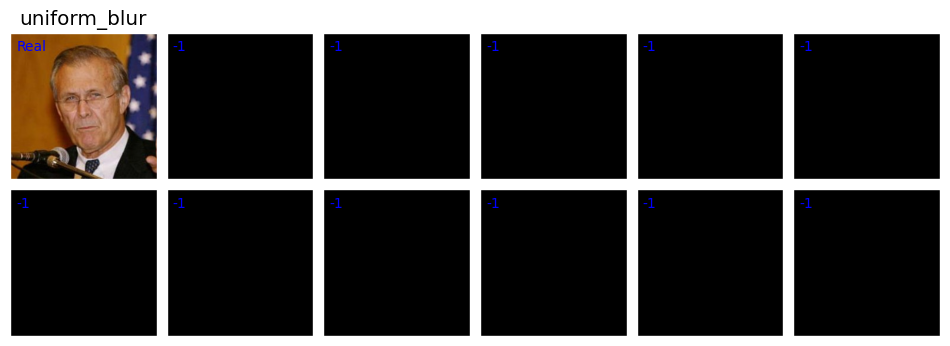

In [7]:
show_faces_of_condition("uniform_blur", blur_kernels, (2, 6), (12.0, 12.0))

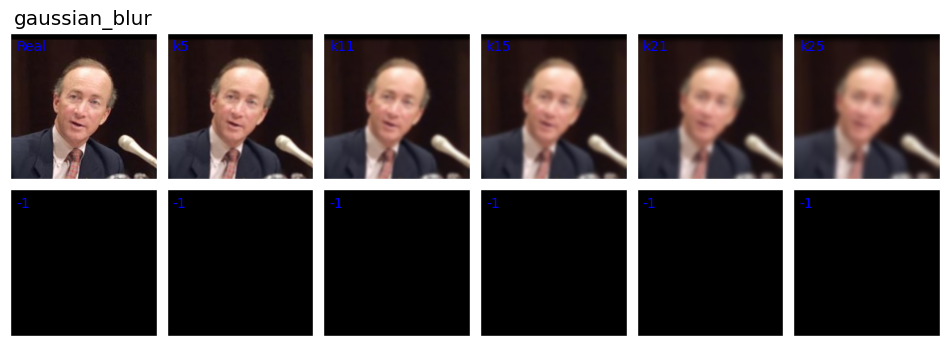

In [8]:
show_faces_of_condition("gaussian_blur", blur_kernels, (2, 6), (12.0, 12.0))

No data for pixel_dp_eps1.0_b1, Results//Privacy//validation//CelebA_test_pixel_dp_eps1.0_b1.csv does not exist!.
No data for pixel_dp_eps2.0_b1, Results//Privacy//validation//CelebA_test_pixel_dp_eps2.0_b1.csv does not exist!.
No data for pixel_dp_eps3.0_b1, Results//Privacy//validation//CelebA_test_pixel_dp_eps3.0_b1.csv does not exist!.
No data for pixel_dp_eps5.0_b1, Results//Privacy//validation//CelebA_test_pixel_dp_eps5.0_b1.csv does not exist!.
No data for pixel_dp_eps7.0_b1, Results//Privacy//validation//CelebA_test_pixel_dp_eps7.0_b1.csv does not exist!.
No data for pixel_dp_eps10.0_b1, Results//Privacy//validation//CelebA_test_pixel_dp_eps10.0_b1.csv does not exist!.
No data for pixel_dp_eps15.0_b1, Results//Privacy//validation//CelebA_test_pixel_dp_eps15.0_b1.csv does not exist!.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No data for pixel_dp_eps1.0_b2, Results//Privacy//validation//CelebA_test_pixel_dp_eps1.0_b2.csv does not exist!.
No data for pixel_dp_eps2.0_b2, Results//Privacy//validation//CelebA_test_pixel_dp_eps2.0_b2.csv does not exist!.
No data for pixel_dp_eps3.0_b2, Results//Privacy//validation//CelebA_test_pixel_dp_eps3.0_b2.csv does not exist!.
No data for pixel_dp_eps5.0_b2, Results//Privacy//validation//CelebA_test_pixel_dp_eps5.0_b2.csv does not exist!.
No data for pixel_dp_eps7.0_b2, Results//Privacy//validation//CelebA_test_pixel_dp_eps7.0_b2.csv does not exist!.
No data for pixel_dp_eps10.0_b2, Results//Privacy//validation//CelebA_test_pixel_dp_eps10.0_b2.csv does not exist!.
No data for pixel_dp_eps15.0_b2, Results//Privacy//validation//CelebA_test_pixel_dp_eps15.0_b2.csv does not exist!.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No data for pixel_dp_eps1.0_b4, Results//Privacy//validation//CelebA_test_pixel_dp_eps1.0_b4.csv does not exist!.
No data for pixel_dp_eps2.0_b4, Results//Privacy//validation//CelebA_test_pixel_dp_eps2.0_b4.csv does not exist!.
No data for pixel_dp_eps3.0_b4, Results//Privacy//validation//CelebA_test_pixel_dp_eps3.0_b4.csv does not exist!.
No data for pixel_dp_eps5.0_b4, Results//Privacy//validation//CelebA_test_pixel_dp_eps5.0_b4.csv does not exist!.
No data for pixel_dp_eps7.0_b4, Results//Privacy//validation//CelebA_test_pixel_dp_eps7.0_b4.csv does not exist!.
No data for pixel_dp_eps10.0_b4, Results//Privacy//validation//CelebA_test_pixel_dp_eps10.0_b4.csv does not exist!.
No data for pixel_dp_eps15.0_b4, Results//Privacy//validation//CelebA_test_pixel_dp_eps15.0_b4.csv does not exist!.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No data for pixel_dp_eps1.0_b8, Results//Privacy//validation//CelebA_test_pixel_dp_eps1.0_b8.csv does not exist!.
No data for pixel_dp_eps2.0_b8, Results//Privacy//validation//CelebA_test_pixel_dp_eps2.0_b8.csv does not exist!.
No data for pixel_dp_eps3.0_b8, Results//Privacy//validation//CelebA_test_pixel_dp_eps3.0_b8.csv does not exist!.
No data for pixel_dp_eps5.0_b8, Results//Privacy//validation//CelebA_test_pixel_dp_eps5.0_b8.csv does not exist!.
No data for pixel_dp_eps7.0_b8, Results//Privacy//validation//CelebA_test_pixel_dp_eps7.0_b8.csv does not exist!.
No data for pixel_dp_eps10.0_b8, Results//Privacy//validation//CelebA_test_pixel_dp_eps10.0_b8.csv does not exist!.
No data for pixel_dp_eps15.0_b8, Results//Privacy//validation//CelebA_test_pixel_dp_eps15.0_b8.csv does not exist!.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No data for pixel_dp_eps1.0_b16, Results//Privacy//validation//CelebA_test_pixel_dp_eps1.0_b16.csv does not exist!.
No data for pixel_dp_eps2.0_b16, Results//Privacy//validation//CelebA_test_pixel_dp_eps2.0_b16.csv does not exist!.
No data for pixel_dp_eps3.0_b16, Results//Privacy//validation//CelebA_test_pixel_dp_eps3.0_b16.csv does not exist!.
No data for pixel_dp_eps5.0_b16, Results//Privacy//validation//CelebA_test_pixel_dp_eps5.0_b16.csv does not exist!.
No data for pixel_dp_eps7.0_b16, Results//Privacy//validation//CelebA_test_pixel_dp_eps7.0_b16.csv does not exist!.
No data for pixel_dp_eps10.0_b16, Results//Privacy//validation//CelebA_test_pixel_dp_eps10.0_b16.csv does not exist!.
No data for pixel_dp_eps15.0_b16, Results//Privacy//validation//CelebA_test_pixel_dp_eps15.0_b16.csv does not exist!.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


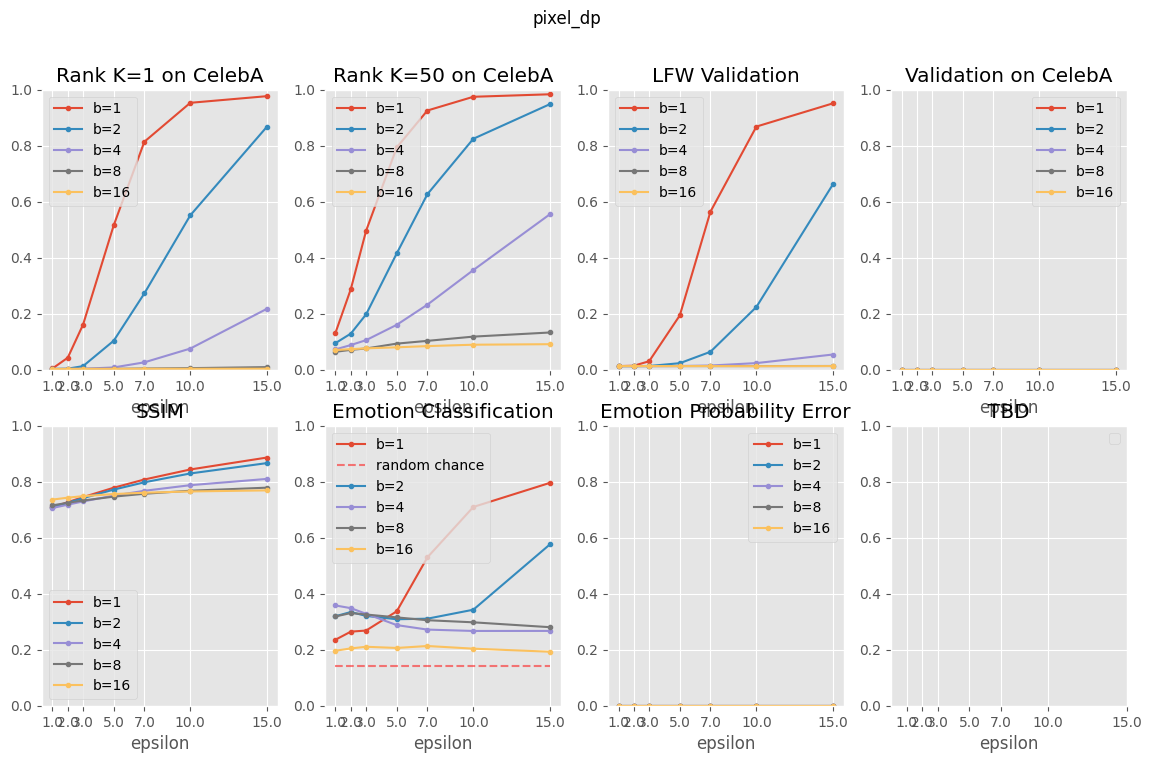

In [9]:
# look at pixel dp
fig, ax = plt.subplots(2, 4)

mechanism = "pixel_dp"

dp_epsilons = [1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0]
bs = [1, 2, 4, 8, 16]
for b in bs:
    suffixes = []
    for dp_eps in dp_epsilons:
        suffixes.append(f"eps{dp_eps}_b{b}")
    plot_results(
        fig,
        ax,
        mechanism,
        x_values=dp_epsilons,
        suffixes=suffixes,
        xlabel_name="epsilon",
        legend_name=f"b={b}",
    )
plt.show()

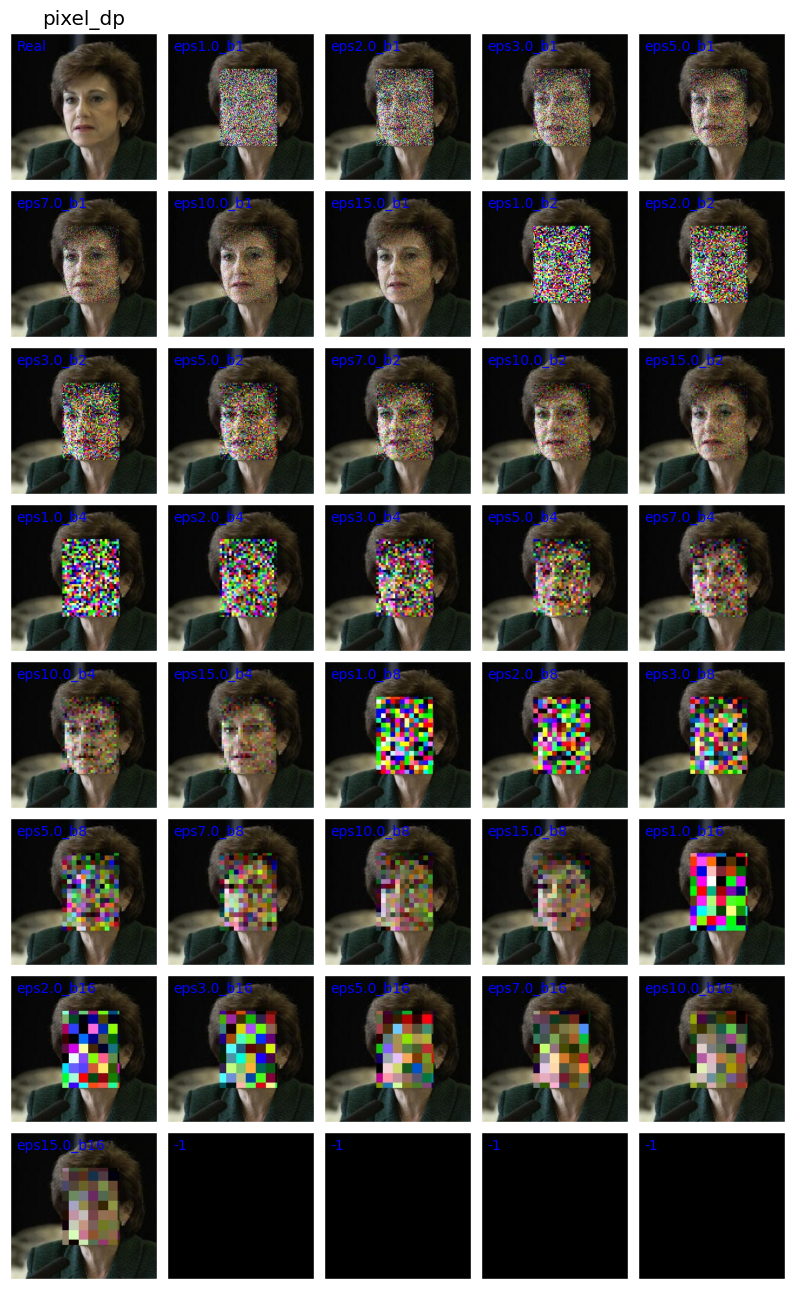

In [10]:
sufs_all = []
for b in [1, 2, 4, 8, 16]:
    sufs = [1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0]
    for i in range(len(sufs)):
        sufs_all.append(f"eps{sufs[i]}_b{b}")


show_faces_of_condition(
    "pixel_dp",
    sufs_all,
    (8, 5),
    (10.0, 20.0),
)

No data for metric_privacy_eps0.1_k4, Results//Privacy//validation//CelebA_test_metric_privacy_eps0.1_k4.csv does not exist!.
No data for metric_privacy_eps0.3_k4, Results//Privacy//validation//CelebA_test_metric_privacy_eps0.3_k4.csv does not exist!.
No data for metric_privacy_eps0.5_k4, Results//Privacy//validation//CelebA_test_metric_privacy_eps0.5_k4.csv does not exist!.
No data for metric_privacy_eps1.0_k4, Results//Privacy//validation//CelebA_test_metric_privacy_eps1.0_k4.csv does not exist!.
No data for metric_privacy_eps2.0_k4, Results//Privacy//validation//CelebA_test_metric_privacy_eps2.0_k4.csv does not exist!.
No data for metric_privacy_eps3.0_k4, Results//Privacy//validation//CelebA_test_metric_privacy_eps3.0_k4.csv does not exist!.
No data for metric_privacy_eps5.0_k4, Results//Privacy//validation//CelebA_test_metric_privacy_eps5.0_k4.csv does not exist!.
No data for metric_privacy_eps7.0_k4, Results//Privacy//validation//CelebA_test_metric_privacy_eps7.0_k4.csv does not 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No data for metric_privacy_eps15.0_k4, Results//Privacy//validation//CelebA_test_metric_privacy_eps15.0_k4.csv does not exist!.
No data for metric_privacy_eps0.1_k6, Results//Privacy//validation//CelebA_test_metric_privacy_eps0.1_k6.csv does not exist!.
No data for metric_privacy_eps0.3_k6, Results//Privacy//validation//CelebA_test_metric_privacy_eps0.3_k6.csv does not exist!.
No data for metric_privacy_eps0.5_k6, Results//Privacy//validation//CelebA_test_metric_privacy_eps0.5_k6.csv does not exist!.
No data for metric_privacy_eps1.0_k6, Results//Privacy//validation//CelebA_test_metric_privacy_eps1.0_k6.csv does not exist!.
No data for metric_privacy_eps2.0_k6, Results//Privacy//validation//CelebA_test_metric_privacy_eps2.0_k6.csv does not exist!.
No data for metric_privacy_eps3.0_k6, Results//Privacy//validation//CelebA_test_metric_privacy_eps3.0_k6.csv does not exist!.
No data for metric_privacy_eps5.0_k6, Results//Privacy//validation//CelebA_test_metric_privacy_eps5.0_k6.csv does no

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No data for metric_privacy_eps15.0_k6, Results//Privacy//validation//CelebA_test_metric_privacy_eps15.0_k6.csv does not exist!.
No data for metric_privacy_eps0.1_k8, Results//Privacy//validation//CelebA_test_metric_privacy_eps0.1_k8.csv does not exist!.
No data for metric_privacy_eps0.3_k8, Results//Privacy//validation//CelebA_test_metric_privacy_eps0.3_k8.csv does not exist!.
No data for metric_privacy_eps0.5_k8, Results//Privacy//validation//CelebA_test_metric_privacy_eps0.5_k8.csv does not exist!.
No data for metric_privacy_eps1.0_k8, Results//Privacy//validation//CelebA_test_metric_privacy_eps1.0_k8.csv does not exist!.
No data for metric_privacy_eps2.0_k8, Results//Privacy//validation//CelebA_test_metric_privacy_eps2.0_k8.csv does not exist!.
No data for metric_privacy_eps3.0_k8, Results//Privacy//validation//CelebA_test_metric_privacy_eps3.0_k8.csv does not exist!.
No data for metric_privacy_eps5.0_k8, Results//Privacy//validation//CelebA_test_metric_privacy_eps5.0_k8.csv does no

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


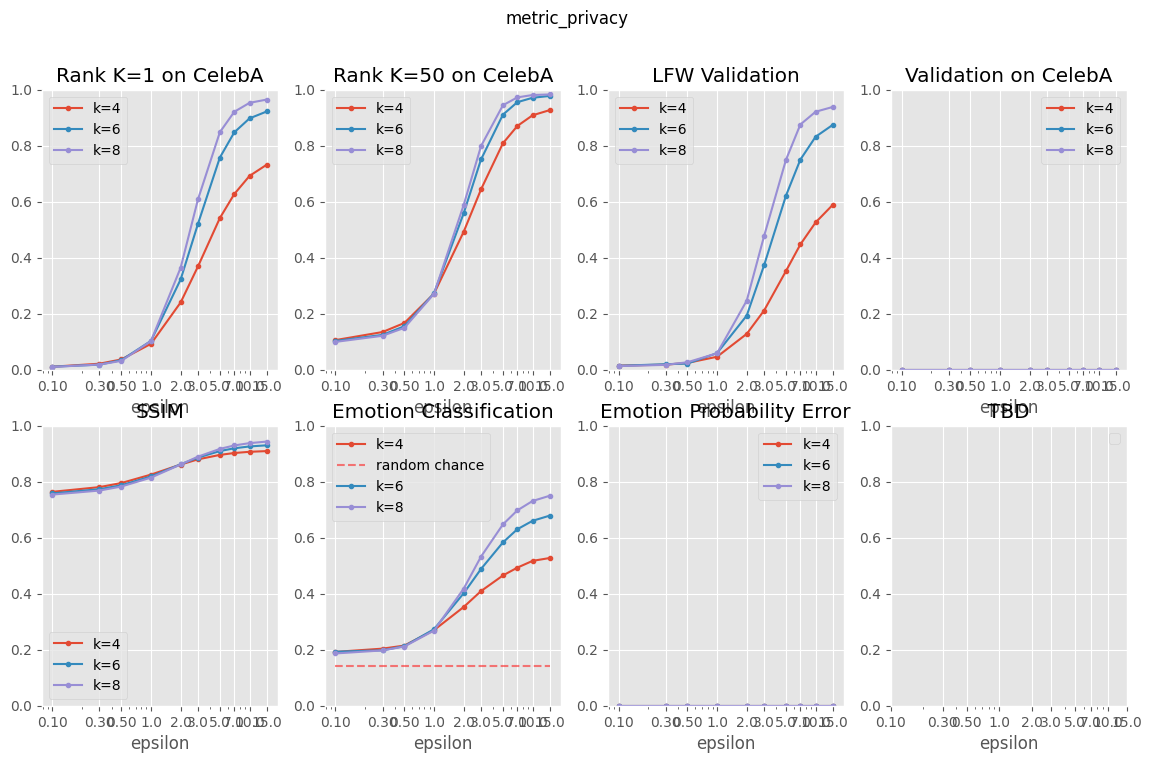

In [11]:
# metric privacy method
fig, ax = plt.subplots(2, 4)

mechanism = "metric_privacy"
dp_epsilons = [0.1, 0.3, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0]
ks = [4, 6, 8]
for k in ks:
    suffixes = []
    for dp_eps in dp_epsilons:
        suffixes.append(f"eps{dp_eps}_k{k}")
    plot_results(
        fig,
        ax,
        mechanism,
        x_values=dp_epsilons,
        suffixes=suffixes,
        xlabel_name="epsilon",
        legend_name=f"k={k}",
    )
plt.show()

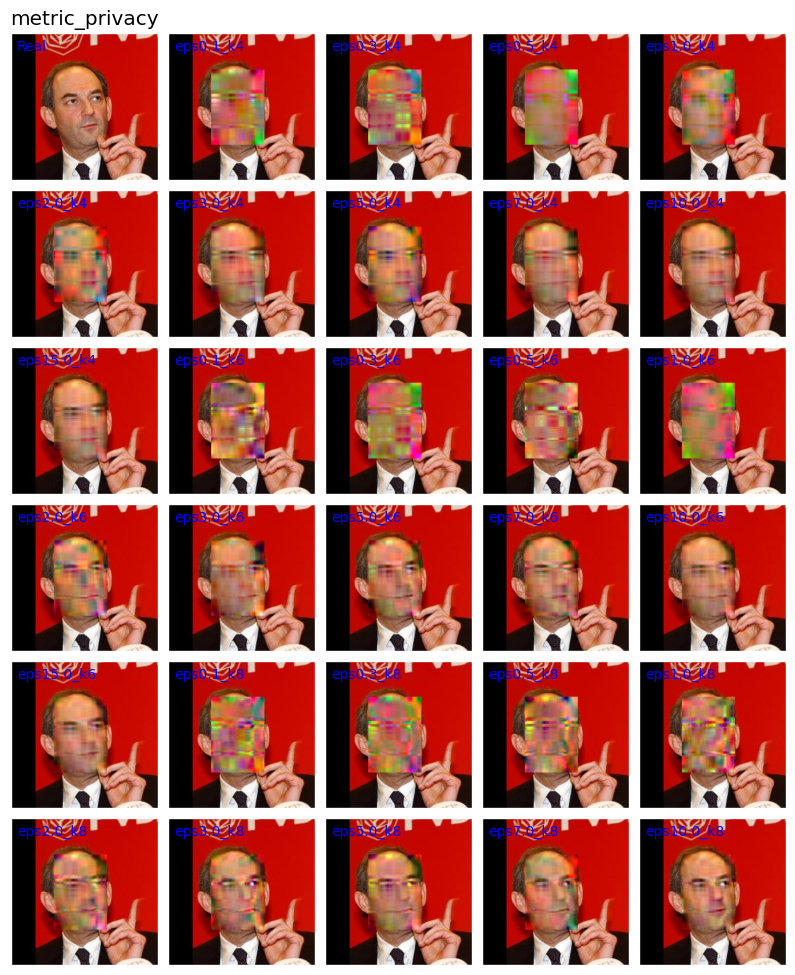

In [12]:
sufs_all = []
for k in [4, 6, 8]:
    sufs = [0.1, 0.3, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0]
    for i in range(len(sufs)):
        sufs_all.append(f"eps{sufs[i]}_k{k}")


show_faces_of_condition(
    "metric_privacy",
    sufs_all,
    (6, 5),
    (10.0, 20.0),
)

No data for identity_dp_eps1.0, Results//Privacy//validation//CelebA_test_identity_dp_eps1.0.csv does not exist!.
No data for identity_dp_eps10.0, Results//Privacy//validation//CelebA_test_identity_dp_eps10.0.csv does not exist!.
No data for identity_dp_eps50.0, Results//Privacy//validation//CelebA_test_identity_dp_eps50.0.csv does not exist!.
No data for identity_dp_eps100.0, Results//Privacy//validation//CelebA_test_identity_dp_eps100.0.csv does not exist!.
No data for identity_dp_eps200.0, Results//Privacy//validation//CelebA_test_identity_dp_eps200.0.csv does not exist!.
No data for identity_dp_eps400.0, Results//Privacy//validation//CelebA_test_identity_dp_eps400.0.csv does not exist!.
No data for identity_dp_eps600.0, Results//Privacy//validation//CelebA_test_identity_dp_eps600.0.csv does not exist!.
No data for identity_dp_eps800.0, Results//Privacy//validation//CelebA_test_identity_dp_eps800.0.csv does not exist!.
No data for identity_dp_eps1000.0, Results//Privacy//validation/

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

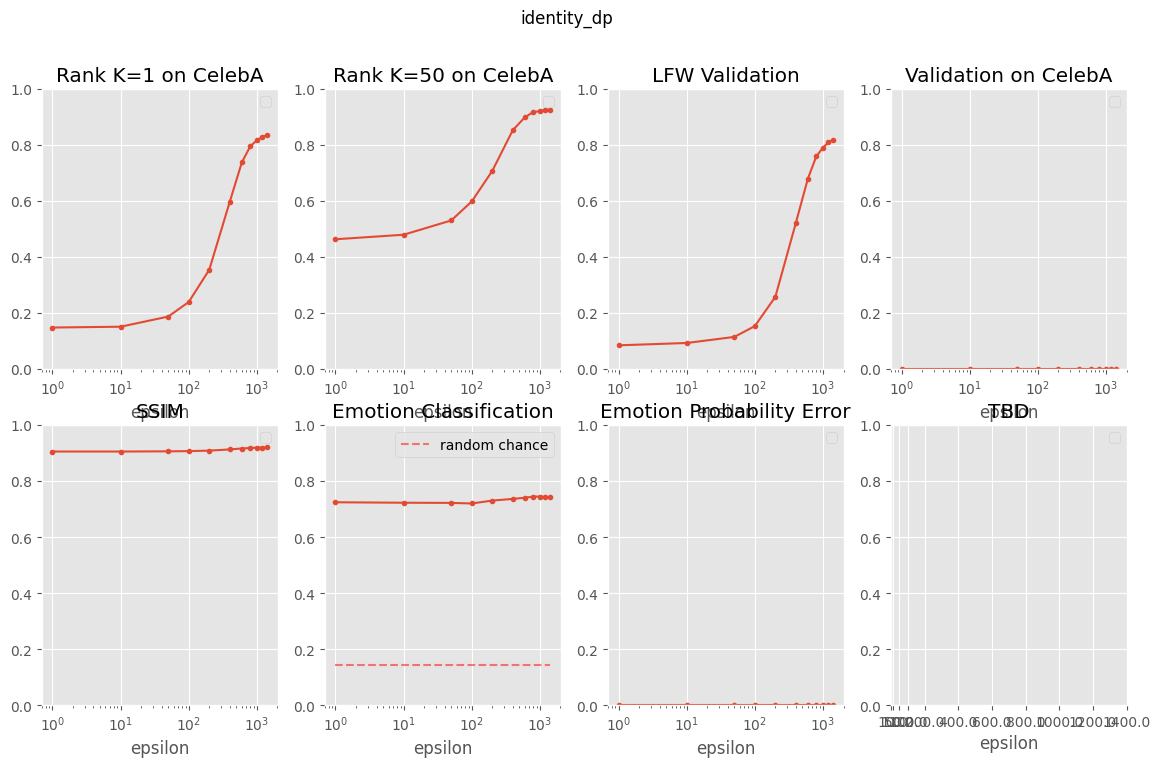

In [13]:
# identitydp method
fig, ax = plt.subplots(2, 4)

mechanism = "identity_dp"
dp_epsilons = [
    1.0,
    10.0,
    50.0,
    100.0,
    200.0,
    400.0,
    600.0,
    800.0,
    1000.0,
    1200.0,
    1400.0,
]
suffixes = []
for dp_eps in dp_epsilons:
    suffixes.append(f"eps{dp_eps}")
plot_results(
    fig,
    ax,
    mechanism,
    x_values=dp_epsilons,
    suffixes=suffixes,
    xlabel_name="epsilon",
)
for i in range(2):
    for j in range(4):
        if i == 1 and j == 3:
            break
        try:
            ax[i, j].set_xscale("log")
        except:
            pass
plt.show()

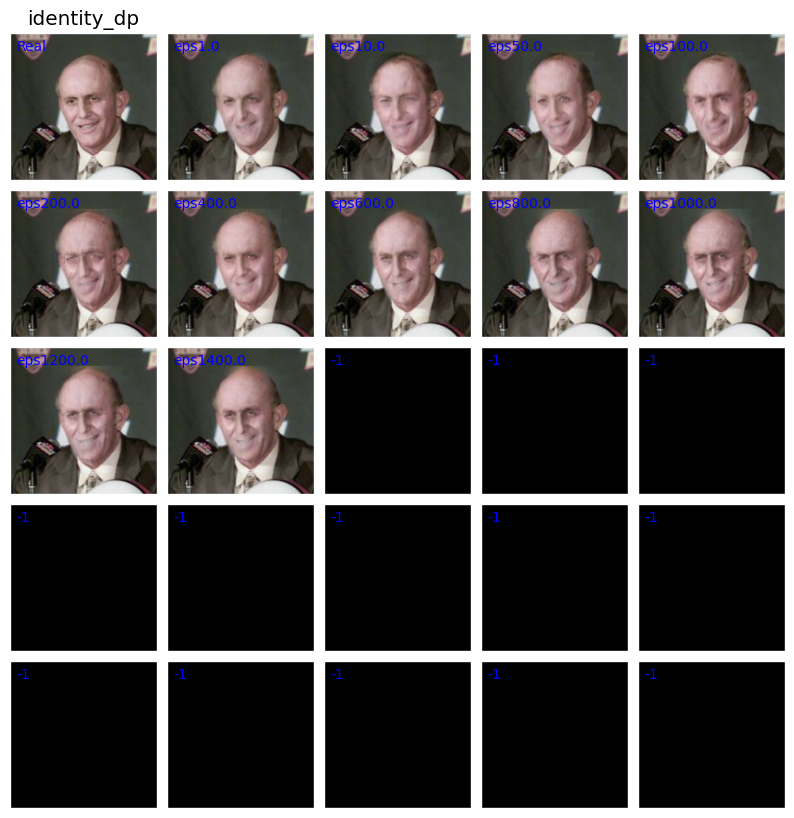

In [14]:
dp_epsilons = [
    1.0,
    10.0,
    50.0,
    100.0,
    200.0,
    400.0,
    600.0,
    800.0,
    1000.0,
    1200.0,
    1400.0,
]
suffixes = []
for dp_eps in dp_epsilons:
    suffixes.append(f"eps{dp_eps}")

show_faces_of_condition(
    "identity_dp",
    suffixes,
    (5, 5),
    (10.0, 20.0),
)

Overlaying all mechanisms privacy-utility clusters:

No data for dcos_metric_privacy_eps0.05, Results//Privacy//rank_k//CelebA_test_dcos_metric_privacy_eps0.05.csv does not exist!.
No data for dcos_metric_privacy_eps0.05, Results//Privacy//lfw_validation//lfw_dcos_metric_privacy_eps0.05.csv does not exist!.
No data for dcos_metric_privacy_eps0.05, Results//Utility//utility//CelebA_test_dcos_metric_privacy_eps0.05.csv does not exist!.
No data for dcos_metric_privacy_eps0.1, Results//Privacy//rank_k//CelebA_test_dcos_metric_privacy_eps0.1.csv does not exist!.
No data for dcos_metric_privacy_eps0.1, Results//Privacy//lfw_validation//lfw_dcos_metric_privacy_eps0.1.csv does not exist!.
No data for dcos_metric_privacy_eps0.1, Results//Utility//utility//CelebA_test_dcos_metric_privacy_eps0.1.csv does not exist!.
No data for dcos_metric_privacy_eps0.25, Results//Privacy//rank_k//CelebA_test_dcos_metric_privacy_eps0.25.csv does not exist!.
No data for dcos_metric_privacy_eps0.25, Results//Privacy//lfw_validation//lfw_dcos_metric_privacy_eps0.25.c

<Figure size 1400x800 with 0 Axes>

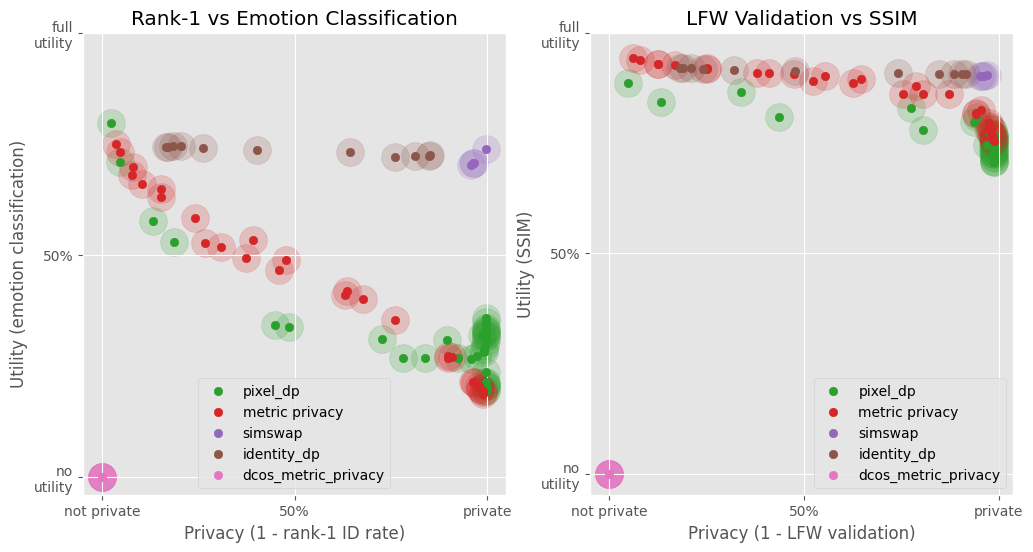

In [15]:
scatter_colors = list(mcolors.TABLEAU_COLORS.values())
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


# # blur
# blur_kernels = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
# mechanisms = ["uniform_blur", "gaussian_blur"]

# for i, mechanism in enumerate(mechanisms):
#     scatter_privacy_utility(
#         fig,
#         ax,
#         mechanism,
#         suffixes=blur_kernels,
#         color=scatter_colors[i],
#         legend_name=mechanism,
#     )

# pixelDP
sufs_all = []
for b in [1, 2, 4, 8, 16]:
    sufs = [1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0]
    for i in range(len(sufs)):
        sufs_all.append(f"eps{sufs[i]}_b{b}")
scatter_privacy_utility(
    fig,
    ax,
    "pixel_dp",
    suffixes=sufs_all,
    color=scatter_colors[2],
    legend_name="pixel_dp",
)

# metric privacy
sufs_all = []
for k in [4, 6, 8]:
    sufs = [0.1, 0.3, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0]
    for i in range(len(sufs)):
        sufs_all.append(f"eps{sufs[i]}_k{k}")
scatter_privacy_utility(
    fig,
    ax,
    "metric_privacy",
    suffixes=sufs_all,
    color=scatter_colors[3],
    legend_name="metric privacy",
)

# simswap
sufs_all = []
for cond in ["random", "all_to_one", "ssim_similarity", "ssim_dissimilarity"]:
    sufs_all.append(f"{cond}")
scatter_privacy_utility(
    fig,
    ax,
    "simswap",
    suffixes=sufs_all,
    color=scatter_colors[4],
    legend_name="simswap",
)

# identitydp
dp_epsilons = [
    1.0,
    10.0,
    50.0,
    100.0,
    200.0,
    400.0,
    600.0,
    800.0,
    1000.0,
    1200.0,
    1400.0,
]
suffixes = []
for dp_eps in dp_epsilons:
    suffixes.append(f"eps{dp_eps}")
scatter_privacy_utility(
    fig,
    ax,
    "identity_dp",
    suffixes=suffixes,
    color=scatter_colors[5],
    legend_name="identity_dp",
)

# dcos metric privacy
epsilons = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]
suffixes = []
for eps in epsilons:
    suffixes.append(f"eps{eps}")
scatter_privacy_utility(
    fig,
    ax,
    "dcos_metric_privacy",
    suffixes=suffixes,
    color=scatter_colors[6],
    legend_name="dcos_metric_privacy",
)

# plt.plot([0, 1], [1, 0], color="k", linestyle="--", alpha=0.5)
plt.show()

.
.
.
.
.
.
.
.
.
.


IndexError: list index out of range

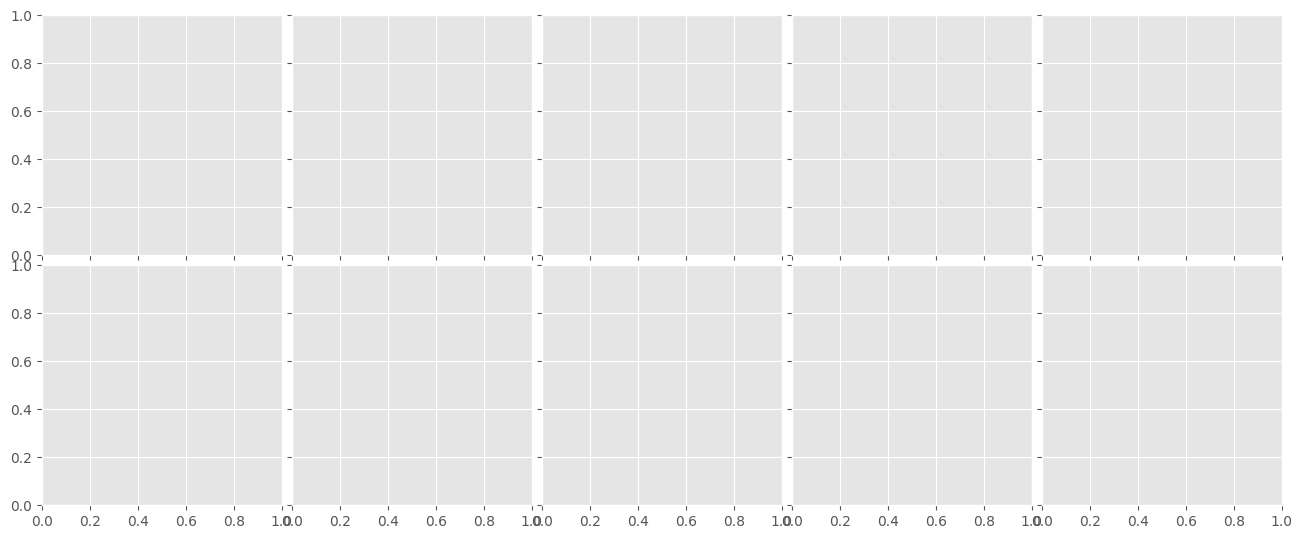

In [16]:
show_multiple_faces_in_conditions(
    "simswap",
    suffixes=["random_seed1", "all_to_one_seed1"],
    numfaces=5,
    figsize=(16.0, 20.0),
)

In [ ]:
fig, ax = plt.subplots(2, 4)

plot_results(
    fig,
    ax,
    "simswap",
    x_values=[1, 2],
    suffixes=["random_seed1", "all_to_one_seed1"],
)
for i in range(4):
    ax[0, i].set_xticks([1, 2], ["random", "all_to_one"])
    ax[0, i].set_xlim([0, 3])
    ax[1, i].set_xticks([1, 2], ["random", "all_to_one"])
    ax[1, i].set_xlim([0, 3])
plt.show()

In [ ]:
# dcos metric privacy
epsilons = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]
suffixes = []
for eps in epsilons:
    suffixes.append(f"eps{eps}")

show_faces_of_condition(
    "dcos_metric_privacy",
    suffixes,
    (4, 3),
    (10.0, 20.0),
)

In [ ]:
fig, ax = plt.subplots(2, 4)

plot_results(
    fig,
    ax,
    "dcos_metric_privacy",
    x_values=epsilons,
    suffixes=suffixes,
)
plt.show()

In [ ]:
scatter_colors = list(mcolors.TABLEAU_COLORS.values())
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# simswap
sufs_all = []
for cond in ["random", "all_to_one"]:
    for seed in [1, 2, 3, 4, 5]:
        sufs_all.append(f"{cond}_seed{seed}")
scatter_privacy_utility(
    fig,
    ax,
    "simswap",
    suffixes=sufs_all,
    color=scatter_colors[4],
    legend_name="face swap (randomly select swapped faces)",
)

# identitydp
dp_epsilons = [
    1.0,
    5.0,
    10.0,
    20.0,
    40.0,
    60.0,
    100.0,
    150.0,
    200.0,
    300.0,
    400.0,
    500.0,
    600.0,
    700.0,
    800.0,
    900.0,
    1000.0,
    1100.0,
    1200.0,
    1300.0,
    1400.0,
    1500.0,
]
suffixes = []
for dp_eps in dp_epsilons:
    suffixes.append(f"eps{dp_eps}")
scatter_privacy_utility(
    fig,
    ax,
    "identity_dp",
    suffixes=suffixes,
    color=scatter_colors[5],
    legend_name="identity_dp",
)

# dcos metric privacy
epsilons = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]
suffixes = []
for eps in epsilons:
    suffixes.append(f"eps{eps}")
scatter_privacy_utility(
    fig,
    ax,
    "dcos_metric_privacy",
    suffixes=suffixes,
    color=scatter_colors[6],
    legend_name="rotated identity",
)

# plt.plot([0, 1], [1, 0], color="k", linestyle="--", alpha=0.5)
plt.show()